# METR 3123 HW \#3 – Due Wednesday March 23 at 11:59 PM.


### This is the jupyter notebook for our 3rd homework assignment.

---

### About our programming framework

Jupyter is a web-based interactive coding framework that many use as their primary programming platform, because its block formatting caters very well to debugging, while the blocks can be a mix of text (like this one), code, and figures.

Please watch the first 3 minutes of this jupyter [tutorial](https://www.youtube.com/watch?v=HW29067qVWk) as an intro. While the remainder of that video covers how to install jupyter on your own machine using Conda, *you are not required to install anything for this assignment.* Kaggle provides an online, fully self-contained approach that removes the need for installing any software. You will complete your assignment by modifying a carbon copy of this notebook.

To run code in this notebook, click on a code block to highlight it, then run it by pressing the Play button in the toolbar (or learn some [keyboard shortcuts](https://gist.github.com/discdiver/9e00618756d120a8c9fa344ac1c375ac)). Do the same thing progressing down the notebook in sequence. In this way, any code error will usually be contained to whichever block you're modifying.

___

### The Assignment

For this assignment we're going to more deeply examine the intense late-January 2022 winter storm that we consdered in Exam 1, which was associated with a very pronounced upper-level trough/ridge pattern and highly ageostrophic flow.

The code blocks below are already set up to read in the data and plot geopotential height and wind at 300 hPa.

**What you will do:** you will modify and add to this code to produce horizontal maps for the 300-hPa level of:
1. Geostrophic wind
2. Ageostrophic wind
3. Relative vorticity

Each of these calculations will lean heavily on the Python function numpy.gradient

I have given you a jump at using this function by calculating the geopotential wind below.

For the assigment you will both submit a link to your notebook through [Gradescope](https://www.gradescope.com/) and answer the questions about your results in the Gradescope assignment form. You are welcome to explore all available time steps and pressure levels, but I am looking for your results and write-up corresponding to p-level = 300 hPa, time = any

---

In [13]:
# load necessary packages:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy

The below command lists the contents of the data directory (7 netcdf files):

In [14]:
!ls data/jan2022/*

data/jan2022/ERA5-jan2022-pl_1000.nc data/jan2022/ERA5-jan2022-pl_500.nc
data/jan2022/ERA5-jan2022-pl_200.nc  data/jan2022/ERA5-jan2022-pl_850.nc
data/jan2022/ERA5-jan2022-pl_300.nc


Each file is a separate pressure level (the numbers in the filename are hPa), containing the following:
- 16 time steps (dt = 6 h), starting at 0000 UTC 27 Oct 2012
- With the variables:
    - "u" - zonal wind (m/s)
    - "v" - meridional ...
    - "w" - vertical ...
    - "t" - temperature (K)
    - "z" - geopotential ($m^2/s^2$)

You'll find variables below that you can modify to change the desired pressure level (changes the input file) and time step to plot.

Note: when read in, variables are organized as $(y, x)$

In [15]:
pressure = '300' # select the pressure level to plot
# nc = Dataset('/kaggle/input/era5jan2022/ERA5-jan2022-pl_'+pressure+'.nc') # this opens the netcdf file
nc = Dataset('data/jan2022/ERA5-jan2022-pl_'+pressure+'.nc') # this opens the netcdf file

In [16]:
# Read in some essential variables

itime = 10 # choose index of time

# horizontal wind components
u = nc.variables['u'][itime, :, :] # result is 2d array (lat, lon), m/s
v = nc.variables['v'][itime, :, :]

# geopotential
phi = nc.variables['z'][itime, :, :] # m2/s2

# Need one-dimensional lat/lon grids for gradient operation
lon1d = nc.variables['longitude'][:]
lat1d = nc.variables['latitude'][:]

# need 2d lat, lon grid to match variable dimensions for plotting
lat, lon = np.meshgrid(nc.variables['latitude'][:], nc.variables['longitude'][:], indexing='ij')

#### Calculate the geostrophic and ageostrophic winds:

$u_g=-\dfrac{1}{f}\dfrac{\partial \phi}{\partial y}$ and $v_g=\dfrac{1}{f}\dfrac{\partial \phi}{\partial x}$

Once we calculate these, we may simply write $u=u_g+u_a$, or $u_a=u-u_g$ (same for $v_a$).

Note that, because we're doing calculations on the globe, we must deal with spherical coordinates, i.e., $\dfrac{\partial}{\partial y} \rightarrow \dfrac{\partial}{a\partial \Phi}$ and $\dfrac{\partial}{ \partial x} \rightarrow \dfrac{\partial}{a \text{cos}(\Phi) \partial \lambda}$, where $\lambda$ is longitude, $a$ is Earth radius, and $\Phi$ is latitude (using uppercase simply to distinguish it from geopotential).

HOWEVER, we may greatly simplify the spherical gradient calculations if we are only focusing on a relatively narrow range of latitude by assuming $a \text{cos}(\Phi) \partial \lambda \approx C\partial \lambda$, where $C=a\text{cos}(\Phi_0)$. I suggest assuming $\Phi_0=35^\circ$. And similarly, let $f = f_0$ for $\Phi=\Phi_0$.

In [17]:
# Necessary constants
omeg = 7.292e-5 # Earth angular velocity, rad/s
a = 6371e3 # radius of earth
deg2rad = np.pi/180.
lat0=35. # assumed constant latitude
deg2m = a*deg2rad # convert from degrees (spherical) to m
f = 2.*omeg*np.sin(lat0*deg2rad)

In [18]:
# Geopotential gradient
gradphi = np.gradient(phi,lat1d,lon1d) # gradient of phi WRT both lat and lon
# See what this looks like:
print("Shape of gradient variable:",np.shape(gradphi))

Shape of gradient variable: (2, 361, 441)


In [19]:
# Geostrophic wind
ug = -1.* gradphi[0] / (deg2m * f)
vg =      gradphi[1] / (deg2m * f * np.cos(lat0 * deg2rad))

# Ageostrophic wind
ua = u - ug
va = v - vg

#### Calculate relative vorticity:

Next, calculate relative vorticity:

$\zeta=\hat k \cdot \nabla \times \vec{U}$

In [20]:
gradu = np.gradient(u,lat1d,lon1d) # gradient of u-wind WRT both lat and lon
gradv = np.gradient(v,lat1d,lon1d) # gradient of u-wind WRT both lat and lon
print("Shape of gradient variable:",np.shape(gradu))

vor = (gradv[1] - gradu[0])/deg2m
vor *= 1e5

Shape of gradient variable: (2, 361, 441)


#### Plotting routines:

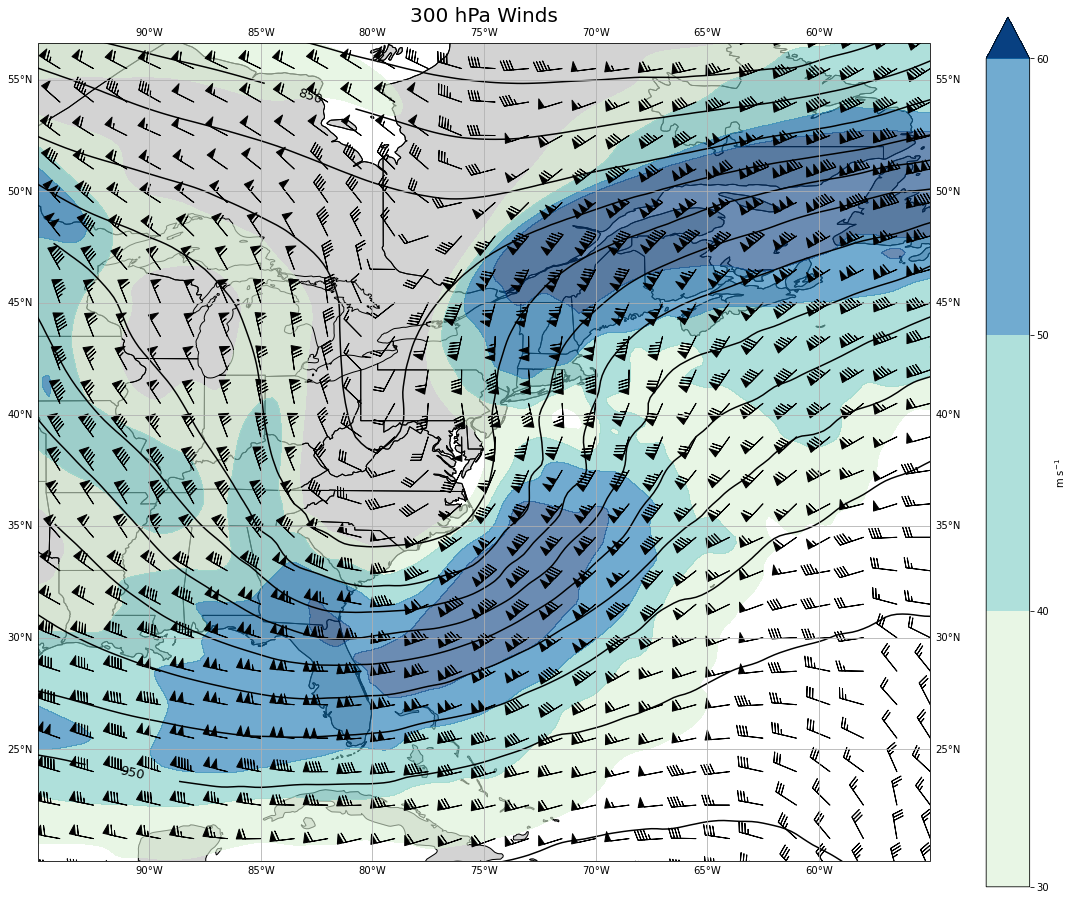

In [21]:
# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N
plt_area=[-95, -55, 20, 55] # W,E,S,N

# create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

# fill contour for wind speed (jet streaks)
# wind speed in m/s
spd = np.sqrt(u**2 + v**2)
clevs_spd = np.arange(30, 70, 10)
im = ax.contourf(lon, lat, spd, clevs_spd, cmap='GnBu', alpha=0.6, \
                 extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')

# line contours of geopotential height (in black)
g=9.81 # m/s^2
geoz = phi / g / 10 # m2/s2 --> m --> dam
clevs_phi = np.arange(800, 1000, 10) # may need to adapt these for the pressure level
im = ax.contour(lon, lat, geoz, clevs_phi, colors='black', projection=cartopy.crs.PlateCarree(), zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

# wind barbs
spacing=6 #barbspacing (smaller if zoomed in)
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = u * mps_to_kts
vplt = v * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt[np.where(spd < 10)] = np.nan
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
ax.set_extent(plt_area)

plt.show()

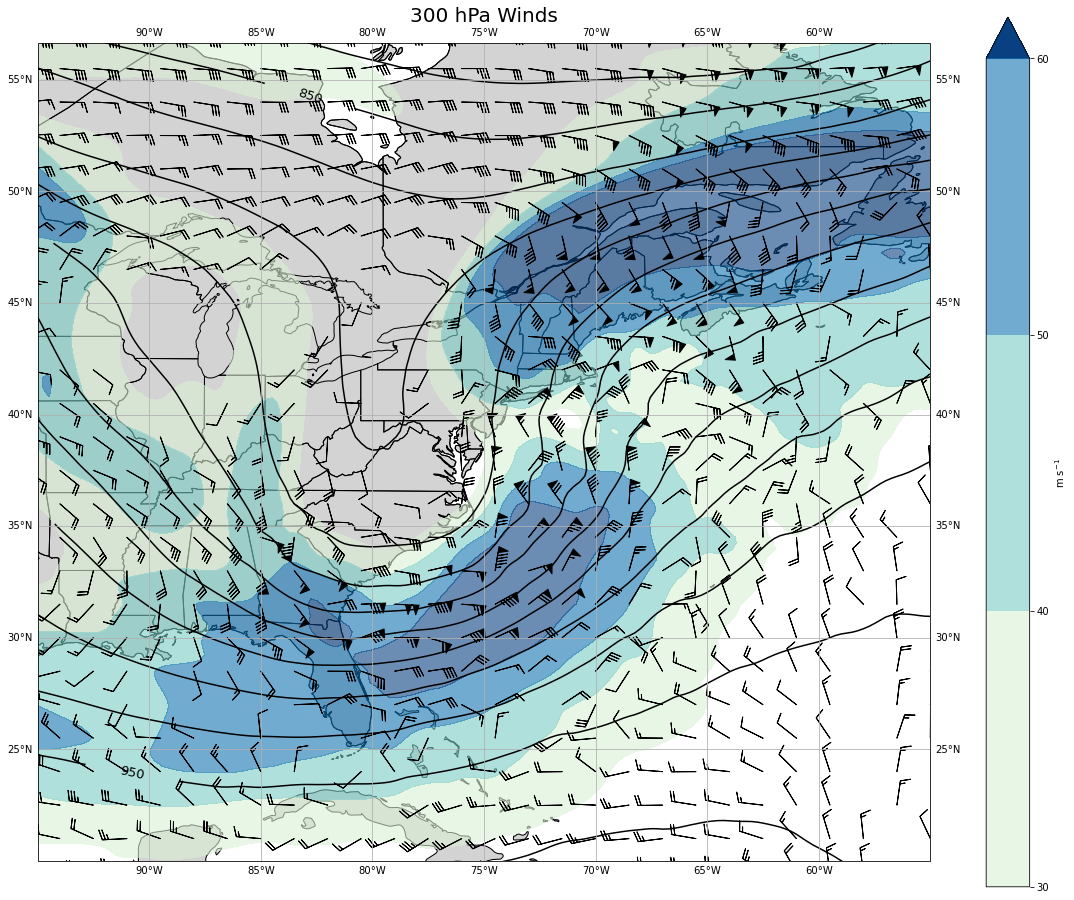

In [22]:
# AGEOSTROPHIC WIND

# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N
plt_area=[-95, -55, 20, 55] # W,E,S,N

# create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

# fill contour for wind speed (jet streaks)
# wind speed in m/s
spd = np.sqrt(u**2 + v**2)
clevs_spd = np.arange(30, 70, 10)
im = ax.contourf(lon, lat, spd, clevs_spd, cmap='GnBu', alpha=0.6, \
                 extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')

# line contours of geopotential height (in black)
g=9.81 # m/s^2
geoz = phi / g / 10 # m2/s2 --> m --> dam
clevs_phi = np.arange(800, 1000, 10) # may need to adapt these for the pressure level
im = ax.contour(lon, lat, geoz, clevs_phi, colors='black', projection=cartopy.crs.PlateCarree(), zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

# wind barbs
spacing=6 #barbspacing (smaller if zoomed in)
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = ua * mps_to_kts
vplt = va * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt[np.where(spd < 10)] = np.nan
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
ax.set_extent(plt_area)

plt.show()

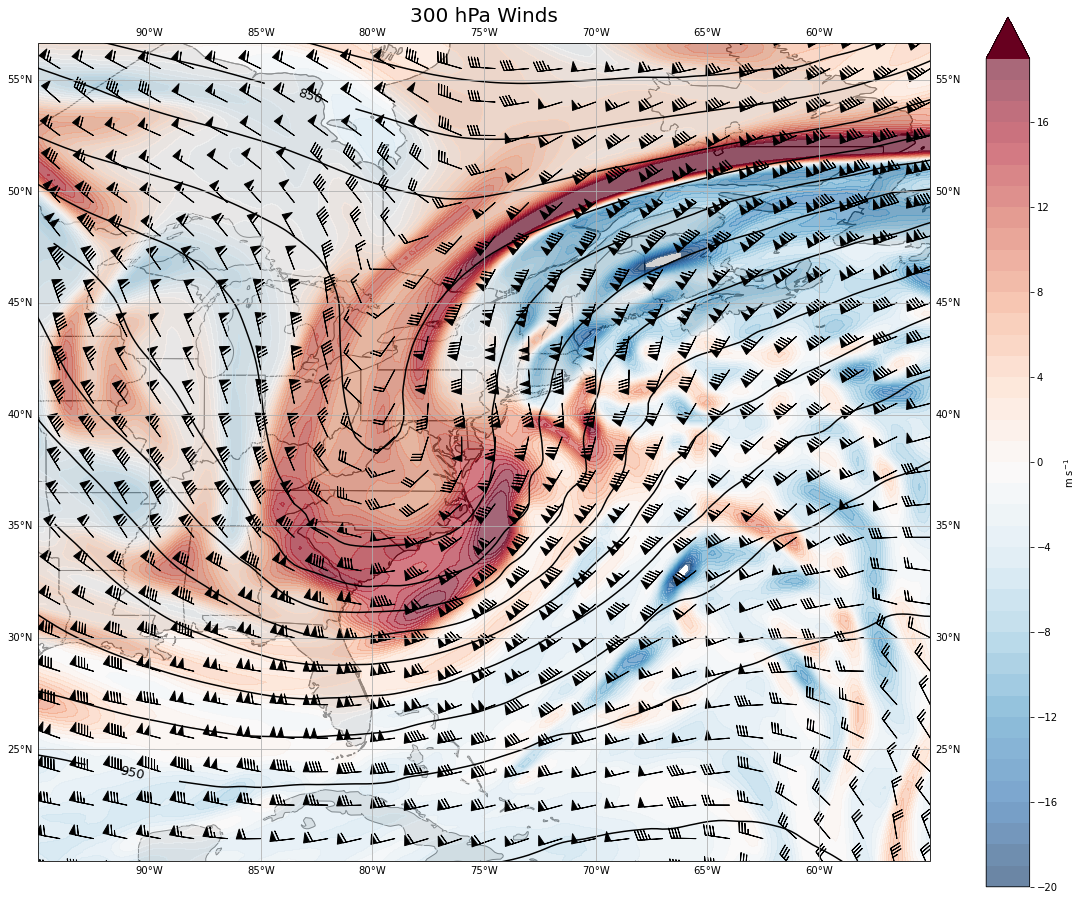

In [23]:
# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N
plt_area=[-95, -55, 20, 55] # W,E,S,N

# create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

# fill contour for wind speed (jet streaks)
# wind speed in m/s
spd = np.sqrt(u**2 + v**2)
clevs_vor = np.arange(-20, 20, 1)
im = ax.contourf(lon, lat, vor, clevs_vor, cmap='RdBu_r', alpha=0.6, \
                 extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')

# line contours of geopotential height (in black)
g=9.81 # m/s^2
geoz = phi / g / 10 # m2/s2 --> m --> dam
clevs_phi = np.arange(800, 1000, 10) # may need to adapt these for the pressure level
im = ax.contour(lon, lat, geoz, clevs_phi, colors='black', projection=cartopy.crs.PlateCarree(), zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

# wind barbs
spacing=6 #barbspacing (smaller if zoomed in)
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = u * mps_to_kts
vplt = v * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt[np.where(spd < 10)] = np.nan
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
ax.set_extent(plt_area)

plt.show()